# Transient Arctic modeling

## Model configuration

<img src='image/fullxml.png' width='768' height='200' alt='transient configuration' align='center' />

## Column model

<img src='image/column.png' width='130' height='360' alt='column mesh' align='left' />  

|Soil layer                                                        |Moss|Peat|Mineral|
|:-----------------------------------------------------------------|:--:|:--:|:-----:|
|Thickness                                                         |2cm |8cm |49.9m  |
|Porosity                                                          |0.9 |0.876|0.596 |
|Permeability ($\mathrm{m}^2$)                                     |1.7e-11|9.38e-12|6e-13|
|Van Genuchten $\alpha$ (Pa$^{-1}$)                                |2.3e-3|9.5e-4|3.3e-4|
|Van Genuchten n                                                   |1.38|1.44|1.33|
|Residual saturation                                               |0.056|0.388|0.334|
|Thermal conductivity, unfrozen ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)|0.446|0.427|0.788|
|Thermal conductivity, dry ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)     |0.024|0.025|0.104|
||||(Atchley el at., 2015)|
|Get forcing data is from Daymet (https://daymet.ornl.gov/single-pixel/api) by ATS tool **daymet_to_ats.py**||||

## Model setup – initialization

freeze.xml
* The purpose is to freeze a soil column from bottom to top to obtain an initial frozen soil domain.
* The freeze-up model has the same configuration with demo 1.
* Initial water table depth = -5.78m
* Run for a long time to reach steady state (1000 years)
* Obtain the final pressure and temperature profile using ATS tool **column_data.py**

## Model setup – transient 

* cycle driver
  - Basic configuration
  - Run for 1 year
* subsurface flow
  - Initial condition: from freezeup
  - Boundary condition: J$_\mathrm{w}$ = 0 
* surface flow
  - Initial condition: from subsurface
  - Boundary condition: outlet at surface; if hillslope, would be possible define the lower side as outlet
* subsurface energy
  - Initial condition: from freezeup
  - Boundary condition: T$_\mathrm{bottom}$ = -10˚C
* surface energy
  - Initial condition: from subsurface
  - Boundary condition: J$_\mathrm{e}$ = 0
* SEB
  - Initial condition: snow depth, could be from the last step of spinup

## Observation

We add **observation** in this model input file.
It is used for collecting some specific modeled results (variables/parameters) 
probably at some specific locations with time. Locations are defined in **region**.

# Model observation

In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append('py_script')
import obsRead
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import sys,os

sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
#sys.path.append(os.path.join('/home/rk/ats_rk/amanzi/src/physics/ats/tools/utils'))
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from datetime import datetime
import matplotlib.image as mpimg

In [3]:
import os
os.getcwd()

'/home/rk/ats_rk/testing/ats-demos/rk_model/Case5_B/04_arctic_hydrology_shortcourse/demo2_transient_column'

In [4]:
#### Extracting the measured data
Yakou_measured_data = pd.read_csv('../../Data/Yakou_data_processed_2017.csv', sep=',',index_col='TIMESTAMP')
Yakou_measured_data.head()

,Wind speed at 10 m (m/s),Wind direction at 10 m (°),Air temperature at 5 m (°C),Relative humidity at 5 m (%),Precipitation at 10 m (mm),Air pressure (hPa),Infrared temperature (°C),Infrared temperature (°C).1,PAR_down,PAR_up,...,Soil temperature at - 0.4 m (°C),Soil temperature at - 0.8 m (°C),Soil temperature at - 1.2 m (°C),Soil temperature at - 1.6 m (°C),Soil temperature at - 0.04 m (K),Soil temperature at - 0.2 m (K),Soil temperature at - 0.4 m (K),Soil temperature at - 0.8 m (K),Soil temperature at - 1.2 m (K),Soil temperature at - 1.6 m (K)
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2017-01-01,5.703646,240.315972,-11.643319,26.417292,0.0,609.727778,-13.595701,-13.473771,23.526389,3.303062,...,-9.902153,-8.312083,-5.657743,-4.284076,261.023264,262.172222,263.247847,264.837917,267.492257,268.865924
2017-01-02,4.522028,215.252083,-12.547639,25.603264,0.0,611.459722,-14.148368,-14.069958,23.598458,3.026146,...,-9.815208,-8.296667,-5.790653,-4.451597,261.006667,262.246458,263.334792,264.853333,267.359347,268.698403
2017-01-03,5.572090,211.012500,-12.374722,43.428264,0.0,609.315278,-14.089813,-14.027125,18.449590,2.359194,...,-9.805000,-8.309931,-5.898486,-4.594007,260.854861,262.184583,263.345000,264.840069,267.251514,268.555993
2017-01-04,6.037000,242.357639,-10.819882,30.436111,0.0,608.171528,-13.654188,-13.519576,24.310958,4.106097,...,-9.844306,-8.356181,-5.995306,-4.716979,261.032708,262.226806,263.305694,264.793819,267.154694,268.433021
2017-01-05,5.978368,196.270833,-10.152083,22.180000,0.0,607.352778,-13.348424,-13.196604,24.258903,2.973646,...,-9.785764,-8.384167,-6.089104,-4.832729,261.347014,262.409792,263.364236,264.765833,267.060896,268.317271


## def (process modeled results)

In [5]:
def modeled(directory):
    obs_dir = os.path.join(directory, 'observation.dat')
    skiprows, header = obsRead.read_file(obs_dir)
    obs_data = np.loadtxt(obs_dir, delimiter=' ', skiprows=skiprows)
        
    time = np.arange(0,366)
    
    wc_surf,evaporation,thaw_depth,\
    T_surf,T_subp10,T_subp40,T_subp100,\
    sl_subp1,sl_subp3,sl_subp5,sl_subp10,\
    si_subp1,si_subp3,si_subp5,si_subp10\
    = (np.zeros((1,len(time))) for i in range(15))

    wc_surf     = obs_data[:,header.index('surface water content [mol]')]/55500*1000
    evaporation = obs_data[:,header.index('evaporation rate [m s^-1]')]*86400*1000
    thaw_depth  = obs_data[:,header.index('thaw depth [m]')]*100
        
    T_surf    = obs_data[:,header.index('surface temperature [K]')]
    T_subp10  = obs_data[:,header.index('point 0.1 temperature [K]')]
    T_subp40  = obs_data[:,header.index('point 0.4 temperature [K]')]
    T_subp100 = obs_data[:,header.index('point 1 temperature [K]')]
    
    sl_subp1  = obs_data[:,header.index('point 0.01 saturation liquid')]
    sl_subp3  = obs_data[:,header.index('point 0.03 saturation liquid')]
    sl_subp5  = obs_data[:,header.index('point 0.05 saturation liquid')]
    sl_subp10 = obs_data[:,header.index('point 0.1 saturation liquid')]
       
    si_subp1  = obs_data[:,header.index('point 0.01 saturation ice')]
    si_subp3  = obs_data[:,header.index('point 0.03 saturation ice')]
    si_subp5  = obs_data[:,header.index('point 0.05 saturation ice')]
    si_subp10 = obs_data[:,header.index('point 0.1 saturation ice')]
        
    # simulated results set
    simset = {}
    simset['surface water content (1e-3 m3)'] = wc_surf
    simset['evaporation (mm/d)']    = evaporation
    simset['thaw depth (cm)']       = thaw_depth
    simset['temperature (K)']       = [T_surf,T_subp10,T_subp40,T_subp100]
    simset['saturation liquid']     = [sl_subp1,sl_subp3,sl_subp5,sl_subp10]
    simset['saturation ice']        = [si_subp1,si_subp3,si_subp5,si_subp10]

    return simset

## def (plot solutions)

Variales to plot include:  
(1) surface water content ($\mathrm{m}^3$)  
(2) evaporation (mm/d)    
(3) thaw depth (cm)  
(4) temperature (K)   
(5) saturation liquid  
(6) saturation ice

In [6]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,365,90))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Solutions

In [7]:
directory = "test.demo"
simset = modeled(directory)

## Plot solutions

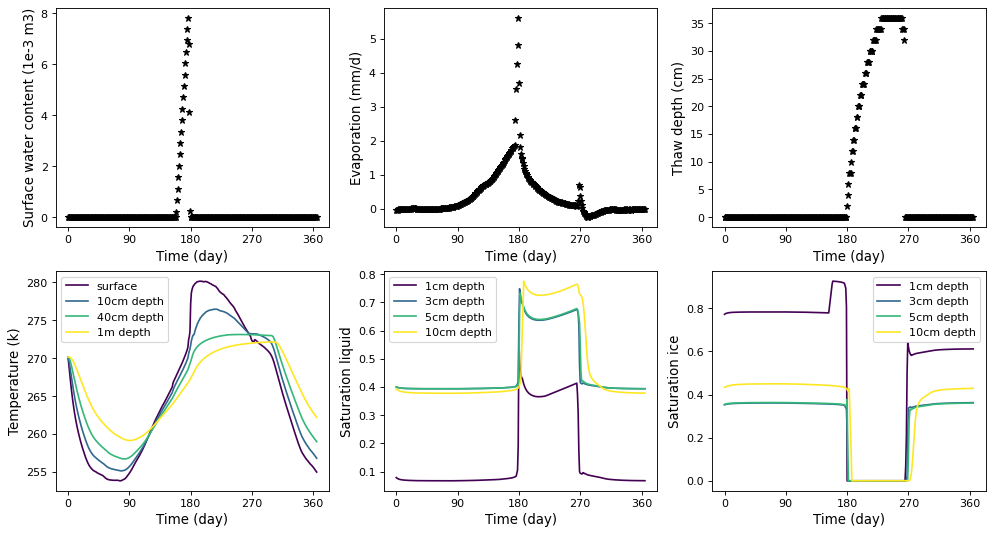

In [8]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

## VisIt visulization

Evolution of ice saturation  

<img src="image/sat_ice.gif" width = "800" height = "1240" alt='s_ice profile' align='center' >

### RK - Work

### Input data -

In [9]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colors
import matplotlib.cm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [10]:
with h5py.File(f'data_input/barrow_71p3225_-156p6231_2011_2020_smooth.h5','r') as hdf:
    ls = list(hdf.keys())
    #print('List of datasets in this file: \n \n', ls)
    #print('\n')
    air_temperature = np.array(hdf.get('air temperature [K]'))
    #print(air_temperature)
    z = np.arange(0,3650)
    data_input = pd.DataFrame(index=z)
    
    #print(data_input)
    for i in ls:
        #print(i)
        data_input[f'{i}'] = np.array(hdf.get(f'{i}'))
        
#data_input['time [days]'] = data_input['time [s]']/86400        
#data_input.index = data_input['time [days]']

#data_input['Air temperature [°C]'] = data_input['air temperature [K]'] - 273.15
data_input.head()

,air temperature [K],incoming shortwave radiation [W m^-2],precipitation rain [m s^-1],precipitation snow [m SWE s^-1],relative humidity [-],time [s],wind speed [m s^-1]
0,251.684990,-0.000462,0.0,5.183254e-09,0.737009,0.0,0.5
1,251.609491,-0.001000,0.0,5.183254e-09,0.737289,86400.0,0.5
2,251.509162,-0.001818,0.0,5.183254e-09,0.738945,172800.0,0.5
3,251.447679,-0.002735,0.0,5.183254e-09,0.739645,259200.0,0.5
4,251.441191,-0.004119,0.0,5.183254e-09,0.739195,345600.0,0.5


In [11]:
data_input.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649],
           dtype='int64', length=3650)

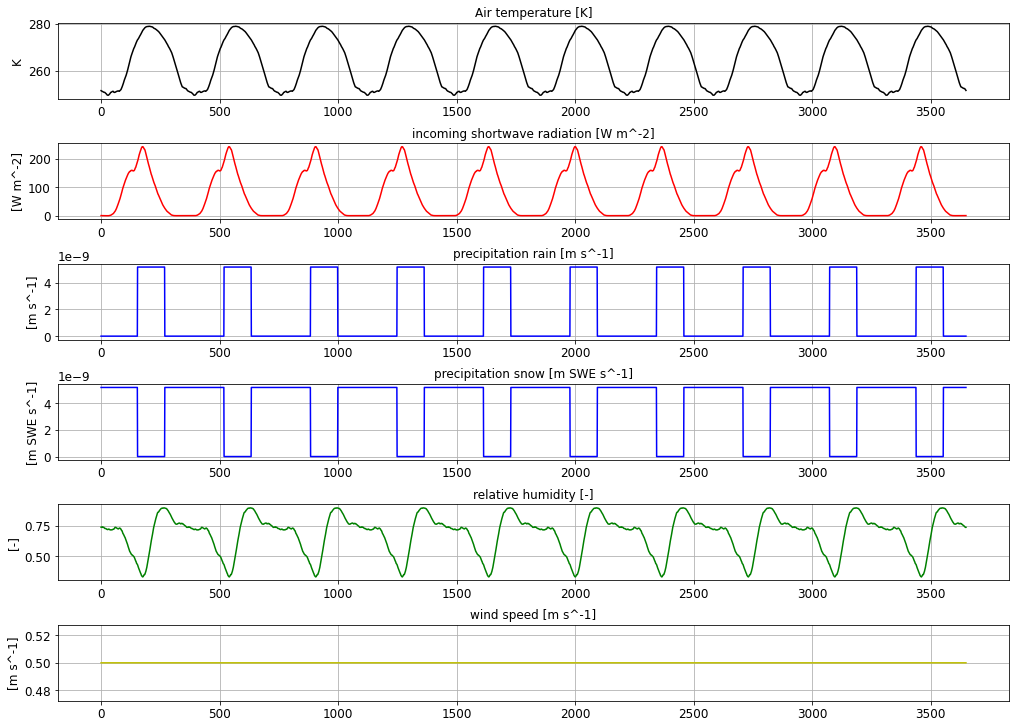

In [12]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Air temperature [K]')
f2_ax1.plot(data_input['air temperature [K]'],'k', label='Air temperature [K]')
f2_ax1.set_ylabel('K')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('incoming shortwave radiation [W m^-2]')
f2_ax2.plot(data_input['incoming shortwave radiation [W m^-2]'],'r', label='incoming shortwave radiation [W m^-2]')
f2_ax2.set_ylabel('[W m^-2]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('precipitation rain [m s^-1]')
f2_ax3.plot(data_input['precipitation rain [m s^-1]'],'b', label='precipitation rain [m s^-1]')
f2_ax3.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax3.grid(True)

f2_ax4.set_title('precipitation snow [m SWE s^-1]')
f2_ax4.plot(data_input['precipitation snow [m SWE s^-1]'],'b', label='precipitation snow [m SWE s^-1]')
f2_ax4.set_ylabel('[m SWE s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax4.grid(True)

f2_ax5.set_title('relative humidity [-]')
f2_ax5.plot(data_input['relative humidity [-]'],'g', label='relative humidity [-]')
f2_ax5.set_ylabel('[-]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax5.grid(True)

f2_ax6.set_title('wind speed [m s^-1]')
f2_ax6.plot(data_input['wind speed [m s^-1]'],'y', label='wind speed [m s^-1]')
f2_ax6.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax6.grid(True)

### Our data

In [13]:
z = np.arange(0,365)
len(z)

365

In [14]:
with h5py.File(f'data_input/Yakou_data_subtemp0cm_2017.h5','r') as hdf:
    ls = list(hdf.keys())
    print(ls)
    air_temp_smoothened = np.array(hdf.get('air temperature [K]'))
    incoming_SW = np.array(hdf.get('Incoming shortwave radiation (W/m^2)'))
    rel_humid = np.array(hdf.get('Relative humidity at 5 m (%)'))
    wind_speed_10m = np.array(hdf.get('Wind speed at 10 m (m/s)'))
    prep = np.array(hdf.get('precipitation rain [m s^-1]'))
    snow = np.array(hdf.get('precipitation snow [m SWE s^-1]'))
    time = np.array(hdf.get('time [s]'))
    soil_temp = np.array(hdf.get('Soil temperature at - 0.00 m (K)'))
    #print(air_temp_smoothened)
    #z = np.arange(0,365)
    #data_input_rk = pd.DataFrame()
    
    #print(data_input)
    #for i in ls:
        #print(i)
        #data_input_rk[f'{i}'] = np.array(hdf.get(f'{i}'))
        
#data_input['time [days]'] = data_input['time [s]']/86400        
#data_input.index = data_input['time [days]']

#data_input['Air temperature [°C]'] = data_input['air temperature [K]'] - 273.15
#data_input_rk.head()

['Incoming shortwave radiation (W', 'Relative humidity at 5 m (%)', 'Soil temperature at - 0.00 m (K)', 'Wind speed at 10 m (m', 'air temperature [K]', 'precipitation rain [m s^-1]', 'precipitation rain [mols m^-2 s^-1]', 'precipitation snow [m SWE s^-1]', 'time [s]']


In [15]:
data_input.columns

Index(['air temperature [K]', 'incoming shortwave radiation [W m^-2]',
       'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]',
       'relative humidity [-]', 'time [s]', 'wind speed [m s^-1]'],
      dtype='object')

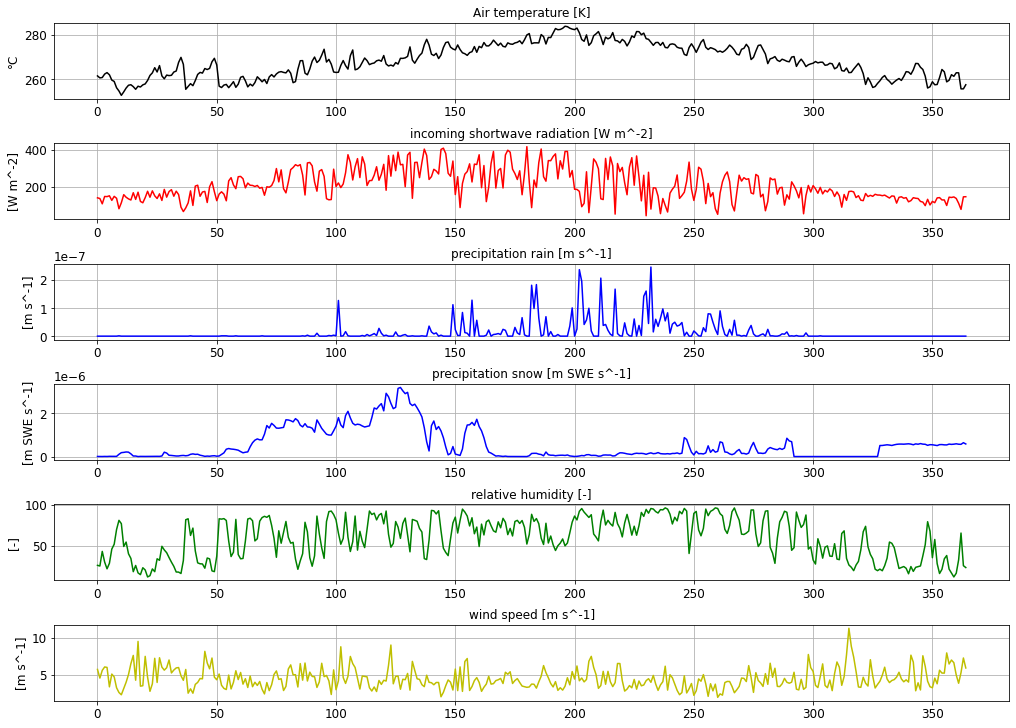

In [16]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Air temperature [K]')
f2_ax1.plot(air_temp_smoothened,'k', label='Air temperature [K]')
f2_ax1.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('incoming shortwave radiation [W m^-2]')
f2_ax2.plot(incoming_SW,'r', label='incoming shortwave radiation [W m^-2]')
f2_ax2.set_ylabel('[W m^-2]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('precipitation rain [m s^-1]')
f2_ax3.plot(prep,'b', label='precipitation rain [m s^-1]')
f2_ax3.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax3.grid(True)

f2_ax4.set_title('precipitation snow [m SWE s^-1]')
f2_ax4.plot(snow,'b', label='precipitation snow [m SWE s^-1]')
f2_ax4.set_ylabel('[m SWE s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax4.grid(True)

f2_ax5.set_title('relative humidity [-]')
f2_ax5.plot(rel_humid,'g', label='relative humidity [-]')
f2_ax5.set_ylabel('[-]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax5.grid(True)

f2_ax6.set_title('wind speed [m s^-1]')
f2_ax6.plot(wind_speed_10m,'y', label='wind speed [m s^-1]')
f2_ax6.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax6.grid(True)

### Checking out the results

In [17]:
obs = pd.read_csv('Case5_B.demo/observation.dat',skiprows=436,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,1.450628e+06,0.000000,1.570124e-02,-0.000001,0.000000,0.000000,0.0,4.340278e-09,8.375843e-06,...,0.77196,0.774074,0.360314,0.374955,0.406567,0.499517,0.600035,0.600036,0.616641,0.616642
1,86400.0,1.452560e+06,88.515269,2.393155e-21,-0.000003,0.154692,-0.003747,0.0,2.411262e-09,2.411262e-09,...,0.00000,0.000000,0.000000,0.368878,0.406276,0.499515,0.600035,0.600036,0.616641,0.616642
2,172800.0,1.453549e+06,102.442128,1.059138e-21,-0.000005,0.228187,-0.031967,0.0,1.446759e-09,1.446759e-09,...,0.00000,0.000000,0.000000,0.399958,0.404969,0.499468,0.600034,0.600035,0.616641,0.616642
3,259200.0,1.454315e+06,92.098071,0.000000e+00,-0.000004,0.171971,-0.029201,0.0,5.304780e-09,5.304780e-09,...,0.00000,0.000000,0.000000,0.265287,0.402860,0.499309,0.600025,0.600035,0.616641,0.616642
4,345600.0,1.454505e+06,87.204283,5.716494e-22,-0.000003,0.148679,-0.002557,0.0,2.893519e-09,2.893519e-09,...,0.00000,0.000000,0.000000,0.000000,0.399669,0.499031,0.599994,0.600034,0.616641,0.616642


In [18]:
df_observation = obs.copy()

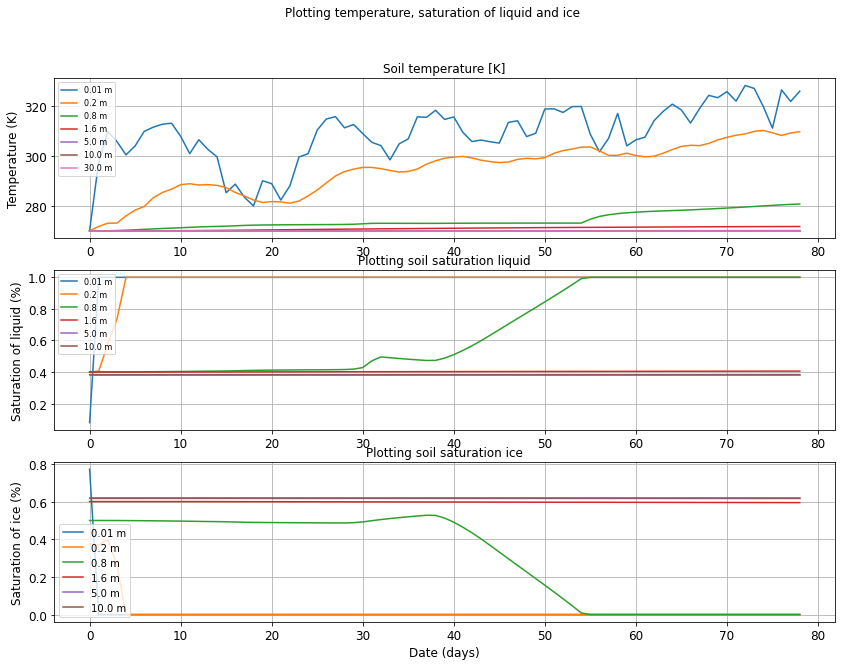

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

## Solutions

In [20]:
def modeled(directory):
    obs_dir = os.path.join(directory, 'observation.dat')
    skiprows, header = obsRead.read_file(obs_dir)
    obs_data = np.loadtxt(obs_dir, delimiter=' ', skiprows=skiprows)
        
    time = np.arange(0,366)
    
    wc_surf,evaporation,thaw_depth,\
    T_surf,T_subp10,T_subp40,T_subp120,\
    sl_subp1,sl_subp3,sl_subp5,sl_subp10,\
    si_subp1,si_subp3,si_subp5,si_subp10\
    = (np.zeros((1,len(time))) for i in range(15))

    wc_surf     = obs_data[:,header.index('surface water content [mol]')]/55500*1000
    evaporation = obs_data[:,header.index('evaporation rate [m s^-1]')]*86400*1000
    thaw_depth  = obs_data[:,header.index('thaw depth [m]')]*100
        
    T_surf    = obs_data[:,header.index('surface temperature [K]')]
    T_subp10  = obs_data[:,header.index('point -0.1 temperature [K]')]
    T_subp40  = obs_data[:,header.index('point -0.4 temperature [K]')]
    T_subp120 = obs_data[:,header.index('point -1.2 temperature [K]')]
    
    sl_subp1  = obs_data[:,header.index('point -0.1 saturation liquid')]
    sl_subp3  = obs_data[:,header.index('point -0.4 saturation liquid')]
    sl_subp5  = obs_data[:,header.index('point -1.2 saturation liquid')]
    sl_subp10 = obs_data[:,header.index('point -1.6 saturation liquid')]
       
    si_subp1  = obs_data[:,header.index('point -0.1 saturation ice')]
    si_subp3  = obs_data[:,header.index('point -0.4 saturation ice')]
    si_subp5  = obs_data[:,header.index('point -0.8 saturation ice')]
    si_subp10 = obs_data[:,header.index('point -1.2 saturation ice')]
        
    # simulated results set
    simset = {}
    simset['surface water content (1e-3 m3)'] = wc_surf
    simset['evaporation (mm/d)']    = evaporation
    simset['thaw depth (cm)']       = thaw_depth
    simset['temperature (K)']       = [T_surf,T_subp10,T_subp40,T_subp120]
    simset['saturation liquid']     = [sl_subp1,sl_subp3,sl_subp5,sl_subp10]
    simset['saturation ice']        = [si_subp1,si_subp3,si_subp5,si_subp10]

    return simset

In [21]:
directory = "Case5_B_weekly.demo"
simset = modeled(directory)

In [22]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,95)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,95,90))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

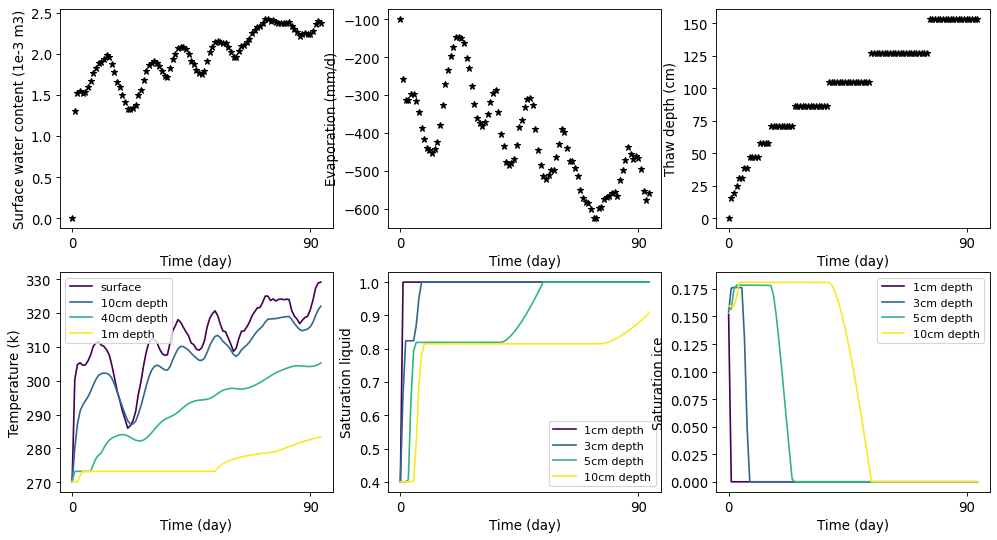

In [23]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [24]:
directory = "Case5_B_monthly.demo"
simset = modeled(directory)

In [25]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,108)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,108,90))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

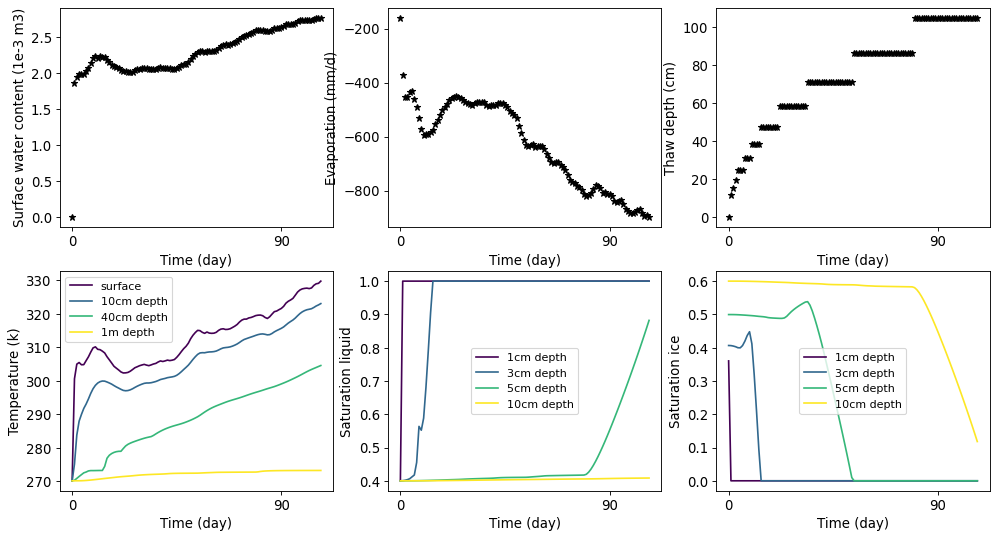

In [26]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [27]:
directory = "Case5_B_monthly_step_process.demo"
simset = modeled(directory)

FileNotFoundError: [Errno 2] No such file or directory: 'Case5_B_monthly_step_process.demo/observation.dat'

In [28]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

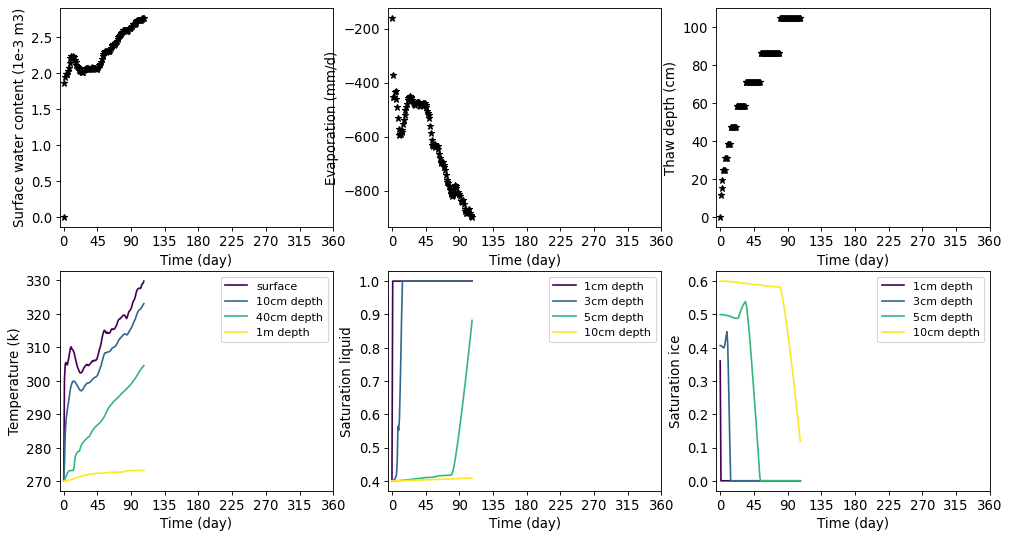

In [29]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

### Checking out the results

In [30]:
obs = pd.read_csv('Case5_B_monthly_exclud_rad_humid.demo/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,1.450628e+06,0.0,0.015701,2.228883e-09,0.0,0.0,0.0,4.340278e-09,0.0,...,0.771960,0.774074,0.360314,0.374955,0.406567,0.499517,0.600035,0.600036,0.616641,0.616642
1,86400.0,1.450628e+06,0.0,0.015830,2.141425e-09,0.0,0.0,0.0,3.375770e-09,0.0,...,0.774073,0.776036,0.361119,0.375248,0.406608,0.499518,0.600036,0.600036,0.616641,0.616642
2,172800.0,1.450628e+06,0.0,0.015868,2.287199e-09,0.0,0.0,0.0,2.732766e-09,0.0,...,0.775847,0.777774,0.362080,0.375858,0.406797,0.499535,0.600037,0.600036,0.616641,0.616642
3,259200.0,1.450628e+06,0.0,0.015947,2.468347e-09,0.0,0.0,0.0,3.375770e-09,0.0,...,0.777241,0.779174,0.362960,0.376555,0.407108,0.499578,0.600042,0.600036,0.616641,0.616642
4,345600.0,1.450628e+06,0.0,0.016004,2.621130e-09,0.0,0.0,0.0,3.279319e-09,0.0,...,0.778287,0.780237,0.363694,0.377231,0.407506,0.499657,0.600054,0.600037,0.616641,0.616642


In [31]:
df_observation = obs.copy()

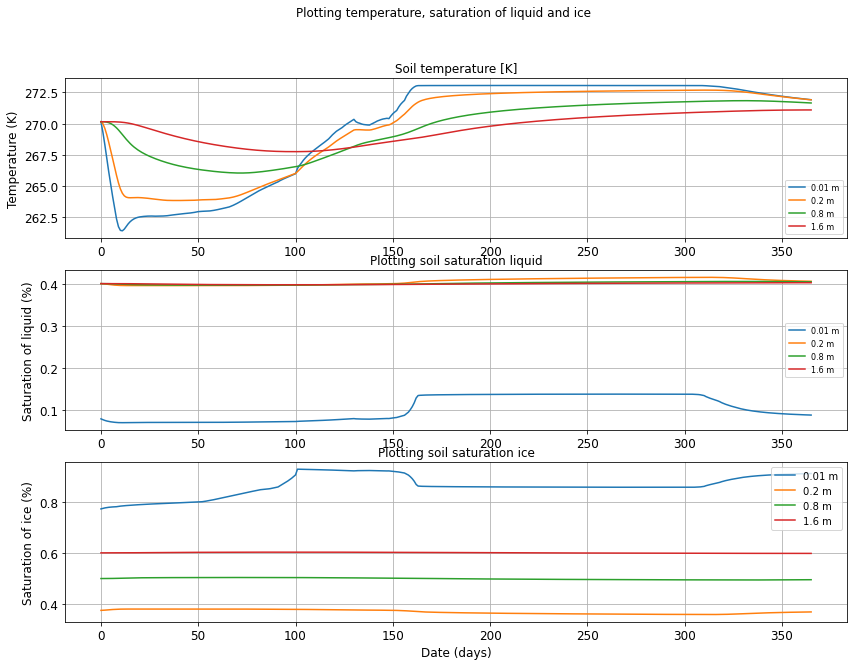

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [33]:
directory = 'Case5_B_monthly_only_airtemp.demo'

In [34]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,1.450628e+06,0.0,0.015701,-4.424690e-13,0.0,0.0,0.0,0.0,0.0,...,0.771960,0.774074,0.360314,0.374955,0.406567,0.499517,0.600035,0.600036,0.616641,0.616642
1,86400.0,1.450628e+06,0.0,0.015701,-5.442317e-13,0.0,0.0,0.0,0.0,0.0,...,0.775303,0.777204,0.361652,0.375467,0.406641,0.499519,0.600036,0.600036,0.616641,0.616642
2,172800.0,1.450628e+06,0.0,0.015701,2.144175e-13,0.0,0.0,0.0,0.0,0.0,...,0.777601,0.779493,0.363035,0.376449,0.406974,0.499550,0.600038,0.600036,0.616641,0.616642
3,259200.0,1.450628e+06,0.0,0.015701,9.813619e-13,0.0,0.0,0.0,0.0,0.0,...,0.779187,0.781109,0.364172,0.377464,0.407498,0.499628,0.600048,0.600036,0.616641,0.616642
4,345600.0,1.450628e+06,0.0,0.015701,1.659607e-12,0.0,0.0,0.0,0.0,0.0,...,0.780263,0.782216,0.365059,0.378360,0.408130,0.499769,0.600069,0.600038,0.616641,0.616642


In [35]:
df_observation = obs.copy()

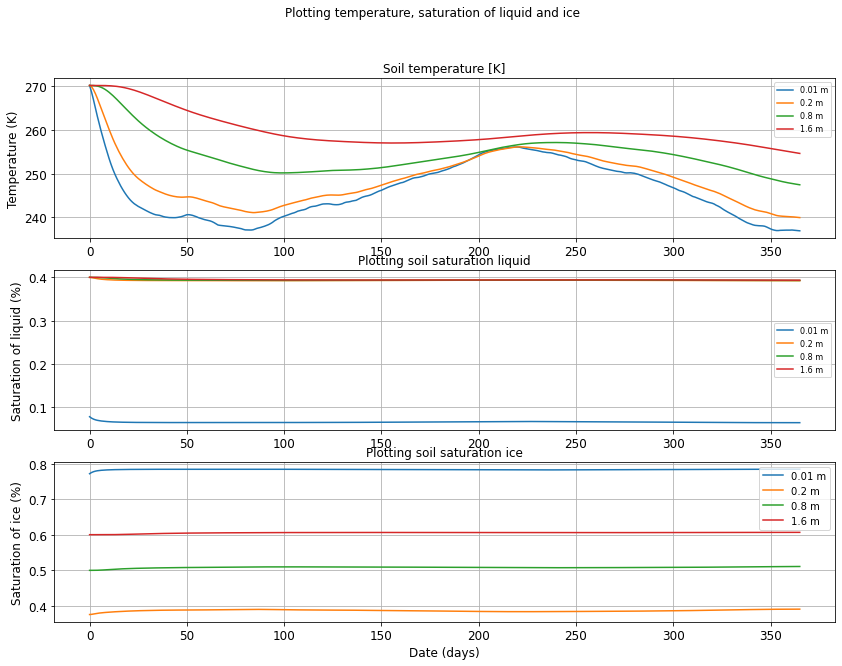

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [37]:
simset = modeled(directory)

In [38]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

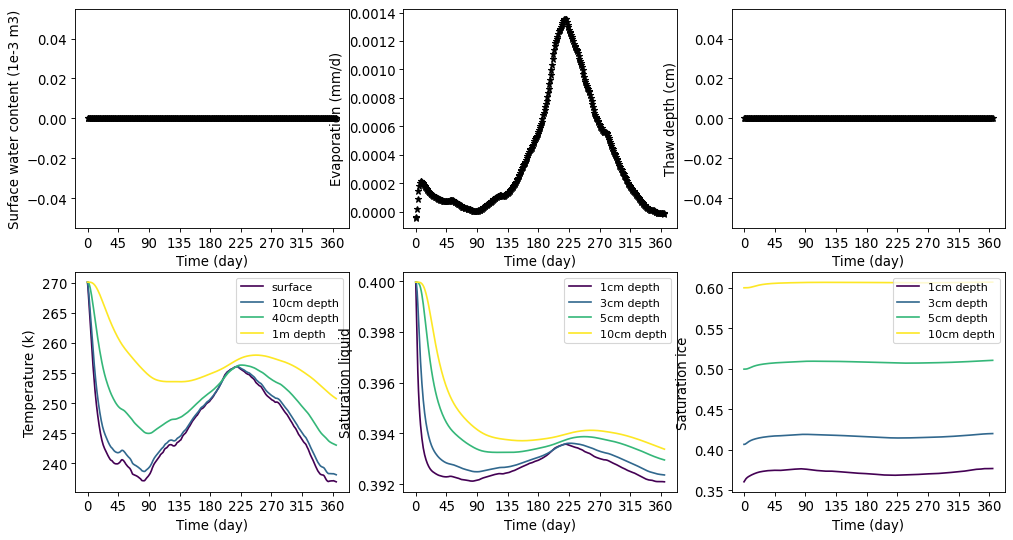

In [39]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [45]:
os.getcwd()

'/home/rk/ats_rk/testing/ats-demos/rk_model/Case5_B/04_arctic_hydrology_shortcourse/demo2_transient_column'

In [42]:
directory = 'Case5_B_monthly_airtemp_prep.demo'

In [44]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Case5_B_monthly_airtemp_prep.demo/observation.dat'

In [105]:
df_observation = obs.copy()

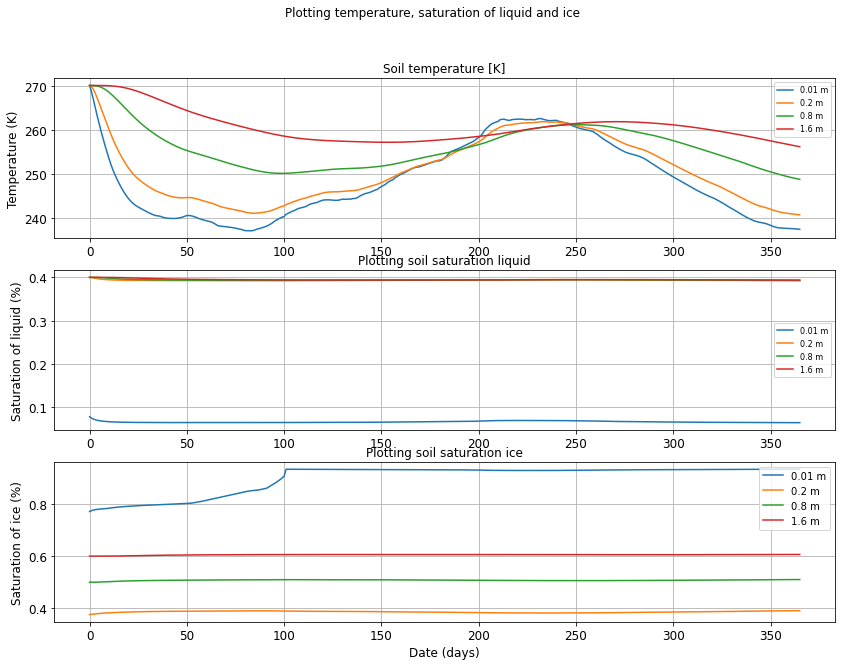

In [106]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [107]:
simset = modeled(directory)

In [108]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

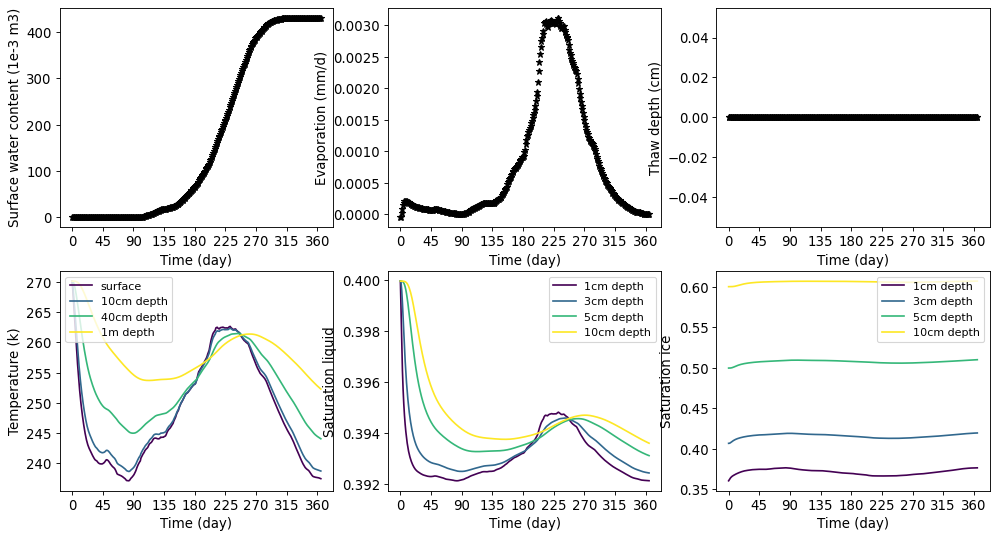

In [109]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [124]:
directory = 'Case5_B_monthly_airtemp_prep_snow.demo'

In [125]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,1.450628e+06,0.0,0.015701,-4.424690e-13,0.0,0.0,0.0,4.340278e-09,0.0,...,0.771960,0.774074,0.360314,0.374955,0.406567,0.499517,0.600035,0.600036,0.616641,0.616642
1,86400.0,1.450628e+06,0.0,0.016017,-5.621010e-13,0.0,0.0,0.0,3.375770e-09,0.0,...,0.775266,0.777169,0.361636,0.375461,0.406640,0.499519,0.600036,0.600036,0.616641,0.616642
2,172800.0,1.450628e+06,0.0,0.016253,1.342559e-13,0.0,0.0,0.0,2.732766e-09,0.0,...,0.777491,0.779385,0.362975,0.376413,0.406964,0.499549,0.600038,0.600036,0.616641,0.616642
3,259200.0,1.450628e+06,0.0,0.016545,7.971710e-13,0.0,0.0,0.0,3.375770e-09,0.0,...,0.779016,0.780940,0.364065,0.377387,0.407467,0.499624,0.600047,0.600036,0.616641,0.616642
4,345600.0,1.450628e+06,0.0,0.016828,1.365819e-12,0.0,0.0,0.0,3.279319e-09,0.0,...,0.780057,0.782010,0.364911,0.378245,0.408069,0.499759,0.600068,0.600038,0.616641,0.616642


In [126]:
df_observation = obs.copy()

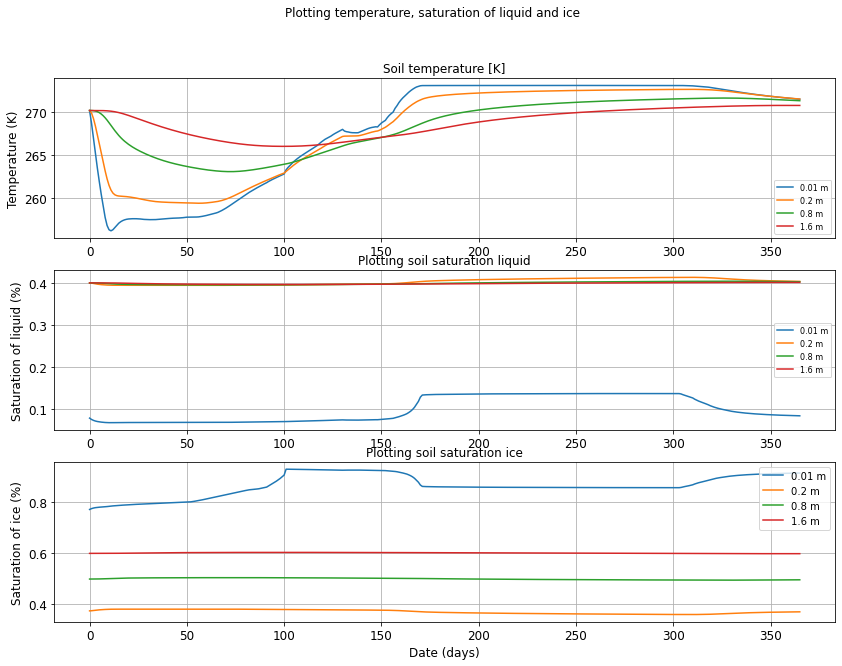

In [127]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [128]:
simset = modeled(directory)

In [131]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

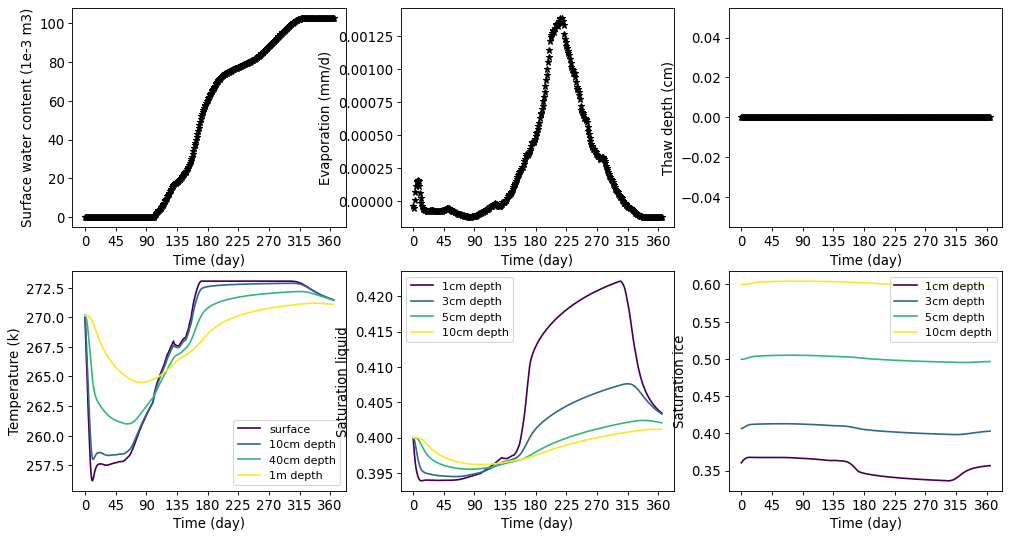

In [132]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [151]:
directory = 'Case5_B_monthly_airtemp_prep_snow_wind.demo'

In [152]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,1.450628e+06,0.0,0.015701,1.068374e-09,0.0,0.0,0.0,4.340278e-09,0.0,...,0.771960,0.774074,0.360314,0.374955,0.406567,0.499517,0.600035,0.600036,0.616641,0.616642
1,86400.0,1.450628e+06,0.0,0.015928,1.016795e-09,0.0,0.0,0.0,3.375770e-09,0.0,...,0.774279,0.776230,0.361205,0.375282,0.406613,0.499518,0.600036,0.600036,0.616641,0.616642
2,172800.0,1.450628e+06,0.0,0.016067,1.125601e-09,0.0,0.0,0.0,2.732766e-09,0.0,...,0.776137,0.778057,0.362231,0.375948,0.406823,0.499537,0.600037,0.600036,0.616641,0.616642
3,259200.0,1.450628e+06,0.0,0.016250,1.248358e-09,0.0,0.0,0.0,3.375770e-09,0.0,...,0.777557,0.779487,0.363149,0.376692,0.407164,0.499585,0.600043,0.600036,0.616641,0.616642
4,345600.0,1.450628e+06,0.0,0.016417,1.350727e-09,0.0,0.0,0.0,3.279319e-09,0.0,...,0.778602,0.780552,0.363899,0.377399,0.407594,0.499672,0.600056,0.600037,0.616641,0.616642


In [153]:
df_observation = obs.copy()

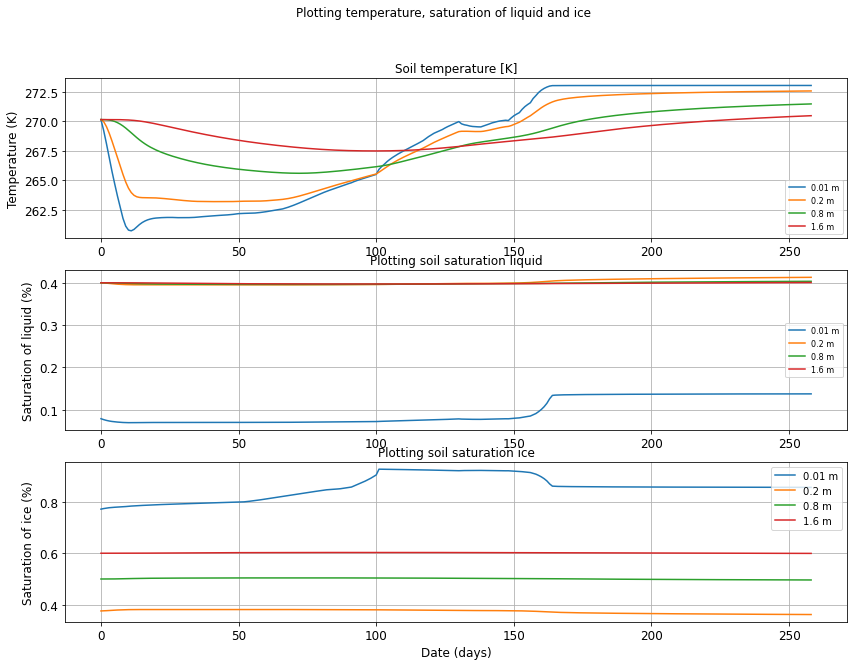

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [155]:
simset = modeled(directory)

In [158]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,259)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

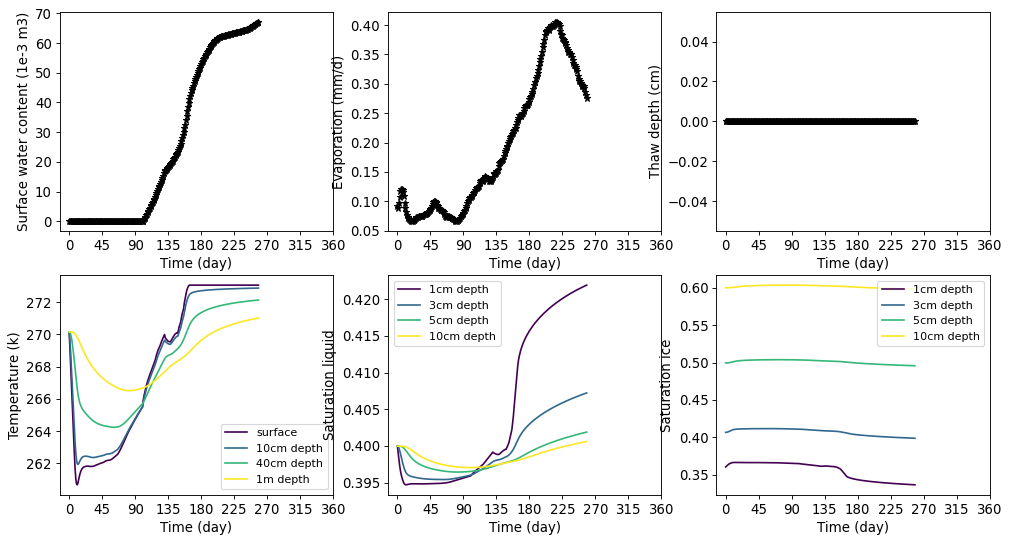

In [159]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [70]:
directory = 'Case5_B_monthly_subtemp_prep.demo'

In [71]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,705948.743581,0.0,0.015701,-5.821512e-13,0.0,0.0,0.0,0.0,0.0,...,0.027414,0.028257,0.222019,0.248992,0.314121,0.556371,0.840477,0.840477,0.949996,0.949996
1,86400.0,705948.743581,0.0,0.015701,-6.871039e-13,0.0,0.0,0.0,0.0,0.0,...,0.027486,0.028306,0.222014,0.248985,0.314115,0.556367,0.840477,0.840477,0.949996,0.949996
2,172800.0,705948.743581,0.0,0.015701,-4.474475e-14,0.0,0.0,0.0,0.0,0.0,...,0.027586,0.028375,0.222010,0.248975,0.314101,0.556353,0.840478,0.840477,0.949996,0.949996
3,259200.0,705948.743581,0.0,0.015701,5.586934e-13,0.0,0.0,0.0,0.0,0.0,...,0.027718,0.028470,0.222015,0.248968,0.314085,0.556332,0.840475,0.840477,0.949996,0.949996
4,345600.0,705948.743581,0.0,0.015701,1.067999e-12,0.0,0.0,0.0,0.0,0.0,...,0.027871,0.028584,0.222032,0.248969,0.314069,0.556305,0.840453,0.840478,0.949996,0.949996


In [72]:
df_observation = obs.copy()

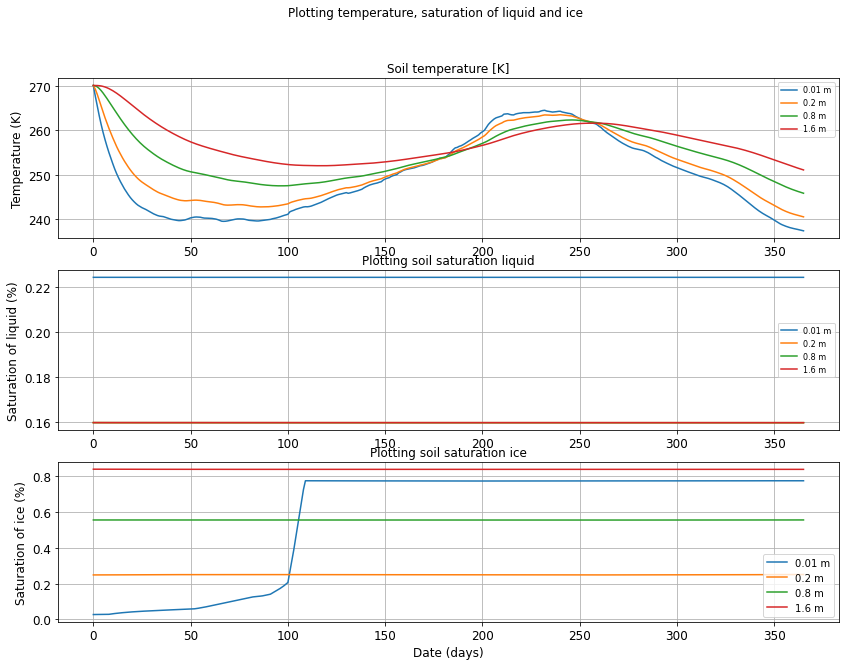

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [74]:
simset = modeled(directory)

In [75]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

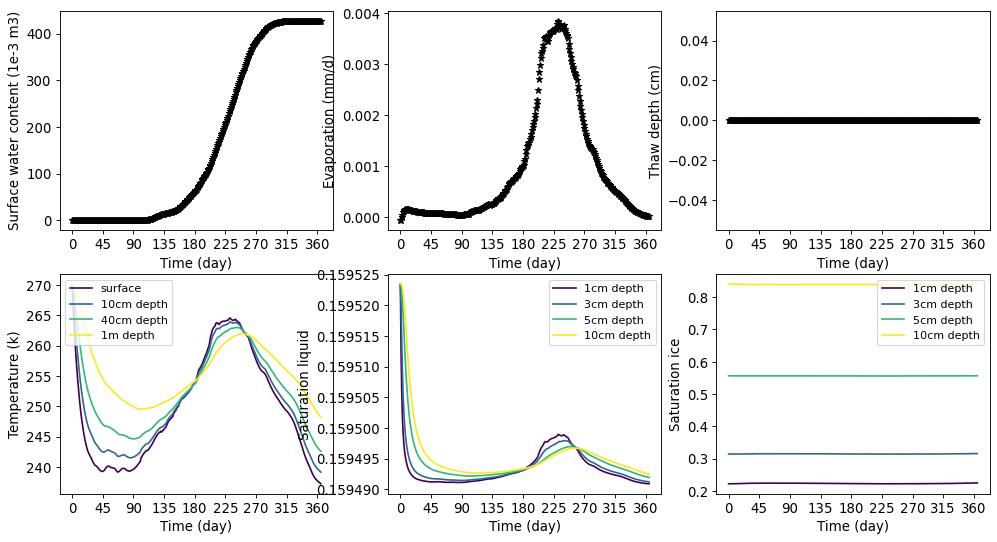

In [76]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [77]:
df_simulated_2017 = df_observation.iloc[1:].copy()
df_simulated_2017.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
1,86400.0,705948.743581,0.0,0.015701,-6.871039e-13,0.0,0.0,0.0,0.0,0.0,...,0.027486,0.028306,0.222014,0.248985,0.314115,0.556367,0.840477,0.840477,0.949996,0.949996
2,172800.0,705948.743581,0.0,0.015701,-4.474475e-14,0.0,0.0,0.0,0.0,0.0,...,0.027586,0.028375,0.222010,0.248975,0.314101,0.556353,0.840478,0.840477,0.949996,0.949996
3,259200.0,705948.743581,0.0,0.015701,5.586934e-13,0.0,0.0,0.0,0.0,0.0,...,0.027718,0.028470,0.222015,0.248968,0.314085,0.556332,0.840475,0.840477,0.949996,0.949996
4,345600.0,705948.743581,0.0,0.015701,1.067999e-12,0.0,0.0,0.0,0.0,0.0,...,0.027871,0.028584,0.222032,0.248969,0.314069,0.556305,0.840453,0.840478,0.949996,0.949996
5,432000.0,705948.743581,0.0,0.015701,1.394138e-12,0.0,0.0,0.0,0.0,0.0,...,0.028039,0.028713,0.222060,0.248978,0.314057,0.556273,0.840424,0.840479,0.949996,0.949996


In [78]:
# Coverting saturation to VWC [Liquid]: VWC = saturation * porosity
porosity_peat = 0.85 # Peat layer until 0.385
porosity_mineral = 0.5 # Mineral layer until 

df_simulated_2017['Soil moisture at - 0.04 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.04 saturation liquid']*porosity_peat*100
df_simulated_2017['Soil moisture at - 0.2 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.2 saturation liquid']*porosity_peat*100
df_simulated_2017['Soil moisture at - 0.4 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.4 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 0.8 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.8 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 1.2 m (VWC %)'] = df_simulated_2017.loc[:,'point -1.2 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 1.6 m (VWC %)'] = df_simulated_2017.loc[:,'point -1.6 saturation liquid']*porosity_mineral*100

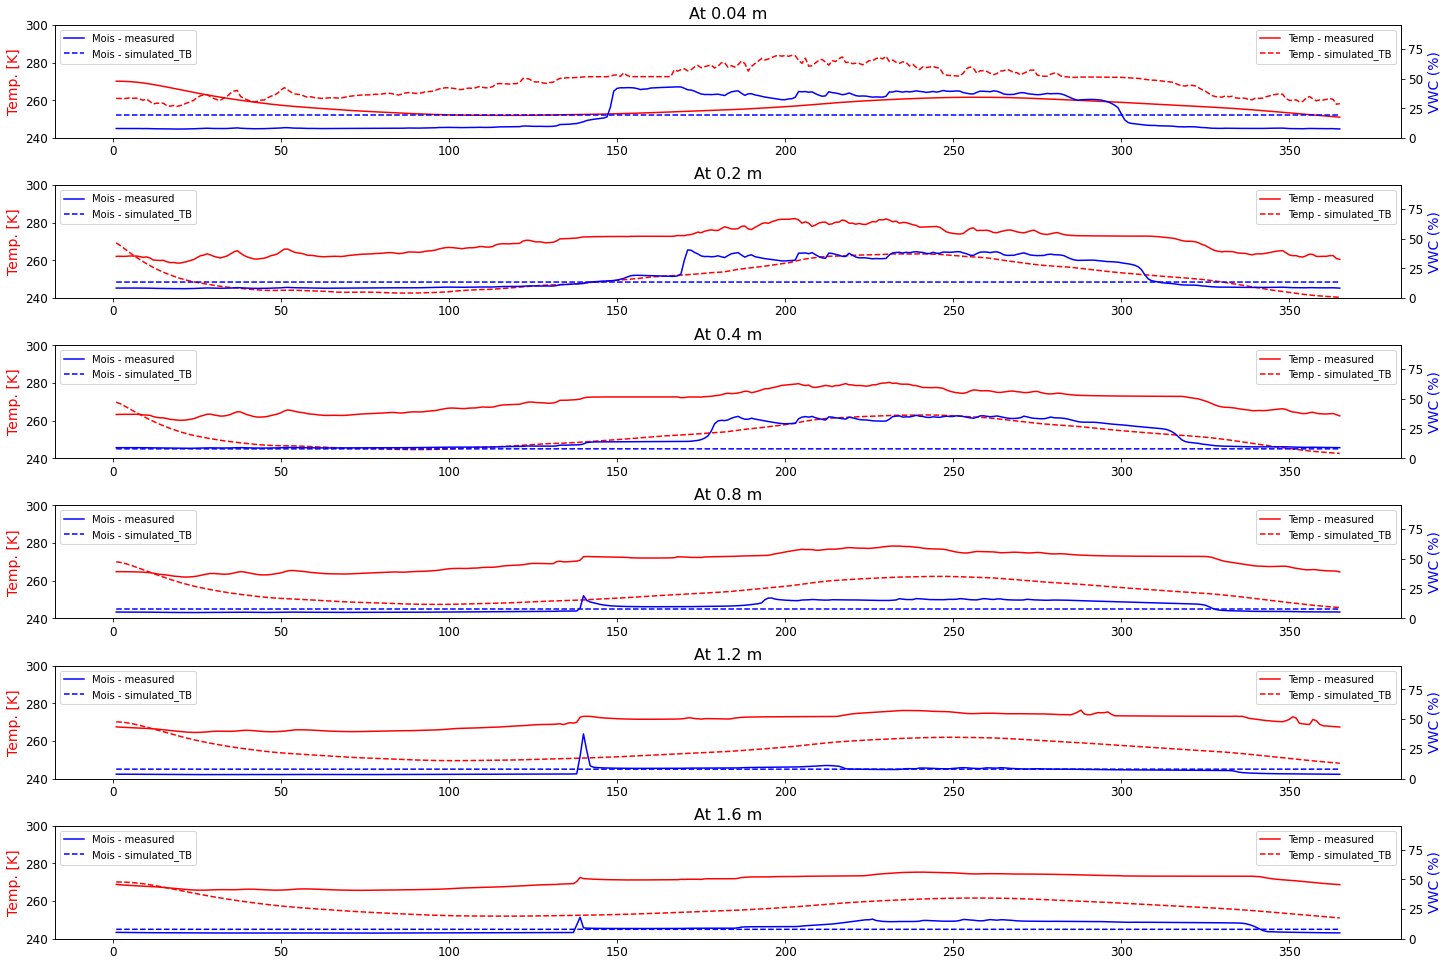

In [81]:
fig2 = plt.figure(figsize=(20,15), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=7, height_ratios=[1,1,1,1,1,1,1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[1, 0])
f2_ax2 = fig2.add_subplot(spec2[2, 0])
f2_ax3 = fig2.add_subplot(spec2[3, 0])
f2_ax4 = fig2.add_subplot(spec2[4, 0])
f2_ax5 = fig2.add_subplot(spec2[5, 0])
f2_ax6 = fig2.add_subplot(spec2[6, 0])

# Defining the x-axis
time = np.arange(1, 366)

# Make a plot

# Plot f2_ax1 - @ 0.04 m
f2_ax1.plot(time, df_simulated_2017['point -1.6 temperature [K]'], 'r',label='Temp - measured')
f2_ax1.plot(time, Yakou_measured_data['Soil temperature at - 0.04 m (K)'],'r--',label='Temp - simulated_TB')
#f2_ax1.plot(time, df_simulated_2017_2['point -0.04 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax1.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax1.set_xlabel('Date', fontsize=15)
f2_ax1.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax1.set_title('At 0.04 m', fontsize=16)
f2_ax1.set_ylim(240, 300)
f2_ax1.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax1.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.04 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.04 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.04 m (VWC %)'], 'k--',label='Mois - simulated')

#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax2 - @ 0.2 m
f2_ax2.plot(time, Yakou_measured_data['Soil temperature at - 0.2 m (K)'], 'r',label='Temp - measured')
f2_ax2.plot(time, df_simulated_2017['point -0.2 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax2.plot(time, df_simulated_2017_2['point -0.2 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax2.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax2.set_xlabel('Date', fontsize=15)
f2_ax2.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax2.set_title('At 0.2 m', fontsize=16)
f2_ax2.set_ylim(240, 300)
f2_ax2.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax2.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.2 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.2 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.2 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax3 - @ 0.4 m
f2_ax3.plot(time, Yakou_measured_data['Soil temperature at - 0.4 m (K)'], 'r',label='Temp - measured')
f2_ax3.plot(time, df_simulated_2017['point -0.4 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax3.plot(time, df_simulated_2017_2['point -0.4 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax3.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax3.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax3.set_title('At 0.4 m', fontsize=16)
f2_ax3.set_ylim(240, 300)
f2_ax3.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax3.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.4 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.4 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.4 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)



# Plot f2_ax4 - @ 0.8 m
f2_ax4.plot(time, Yakou_measured_data['Soil temperature at - 0.8 m (K)'], 'r',label='Temp - measured')
f2_ax4.plot(time, df_simulated_2017['point -0.8 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax4.plot(time, df_simulated_2017_2['point -0.8 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax4.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax4.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax4.set_title('At 0.8 m', fontsize=16)
f2_ax4.set_ylim(240, 300)
f2_ax4.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax4.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.8 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.8 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.8 m (VWC %)'], 'k--',label='Mois - simulated')

#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax4 - @ 1.2 m
f2_ax5.plot(time, Yakou_measured_data['Soil temperature at - 1.2 m (K)'], 'r',label='Temp - measured')
f2_ax5.plot(time, df_simulated_2017['point -1.2 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax5.plot(time, df_simulated_2017_2['point -1.2 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax5.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax5.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax5.set_title('At 1.2 m', fontsize=16)
f2_ax5.set_ylim(240, 300)
f2_ax5.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax5.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 1.2 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 1.2 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 1.2 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)



# Plot f2_ax6 - @ 1.6 m
f2_ax6.plot(time, Yakou_measured_data['Soil temperature at - 1.6 m (K)'], 'r',label='Temp - measured')
f2_ax6.plot(time, df_simulated_2017['point -1.6 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax6.plot(time, df_simulated_2017_2['point -1.6 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax6.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax6.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax6.set_title('At 1.6 m', fontsize=16)
f2_ax6.set_ylim(240, 300)
f2_ax6.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax6.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 1.6 m (%)'], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 1.6 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 1.6 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

In [58]:
directory = 'Case5_B_monthly_subtemp_prep_sw.demo'

In [59]:
obs = pd.read_csv(f'{directory}/observation.dat',skiprows=274,sep=' ')
obs.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
0,0.0,705948.743581,0.0,0.015701,2.371573e-12,0.0,0.0,0.0,0.0,0.0,...,0.027414,0.028257,0.222019,0.248992,0.314121,0.556371,0.840477,0.840477,0.949996,0.949996
1,86400.0,705948.743581,0.0,0.015701,2.027689e-12,0.0,0.0,0.0,0.0,0.0,...,0.027476,0.028299,0.222014,0.248985,0.314116,0.556367,0.840477,0.840477,0.949996,0.949996
2,172800.0,705948.743581,0.0,0.015701,3.000921e-12,0.0,0.0,0.0,0.0,0.0,...,0.027559,0.028357,0.222010,0.248977,0.314104,0.556355,0.840477,0.840477,0.949996,0.949996
3,259200.0,705948.743581,0.0,0.015700,4.453412e-12,0.0,0.0,0.0,0.0,0.0,...,0.027662,0.028433,0.222012,0.248970,0.314089,0.556337,0.840478,0.840477,0.949996,0.949996
4,345600.0,705948.743581,0.0,0.015700,5.738699e-12,0.0,0.0,0.0,0.0,0.0,...,0.027779,0.028522,0.222022,0.248968,0.314075,0.556313,0.840459,0.840478,0.949996,0.949996


In [60]:
df_observation = obs.copy()

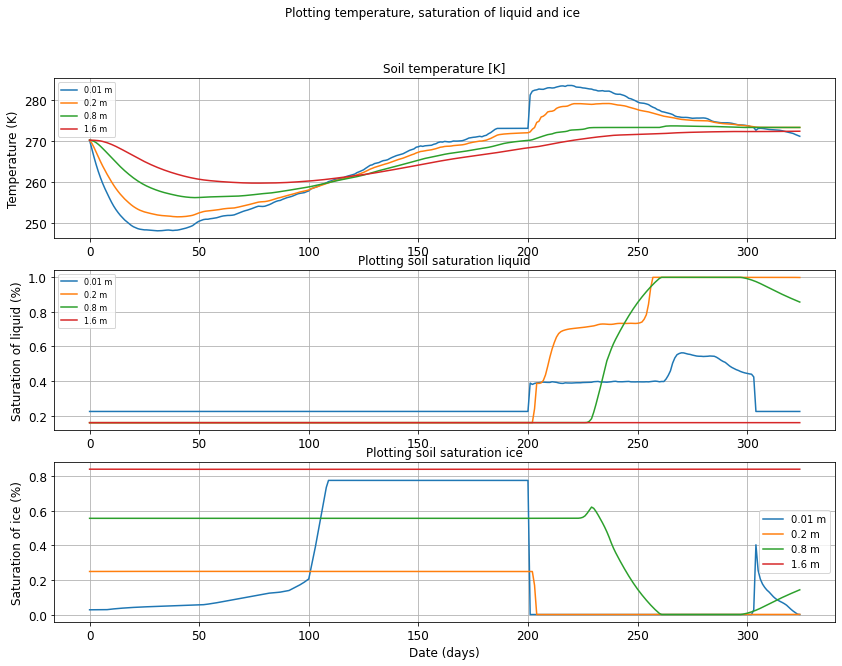

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
#ax1.plot(air_temp_2017_5yrs, 'k',label='air temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
#ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'],label='0.01 m')
#ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'],label='0.01 m')
#ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
#ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
#ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)

In [62]:
simset = modeled(directory)

In [63]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot( simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot( simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,366,45))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Plot solutions

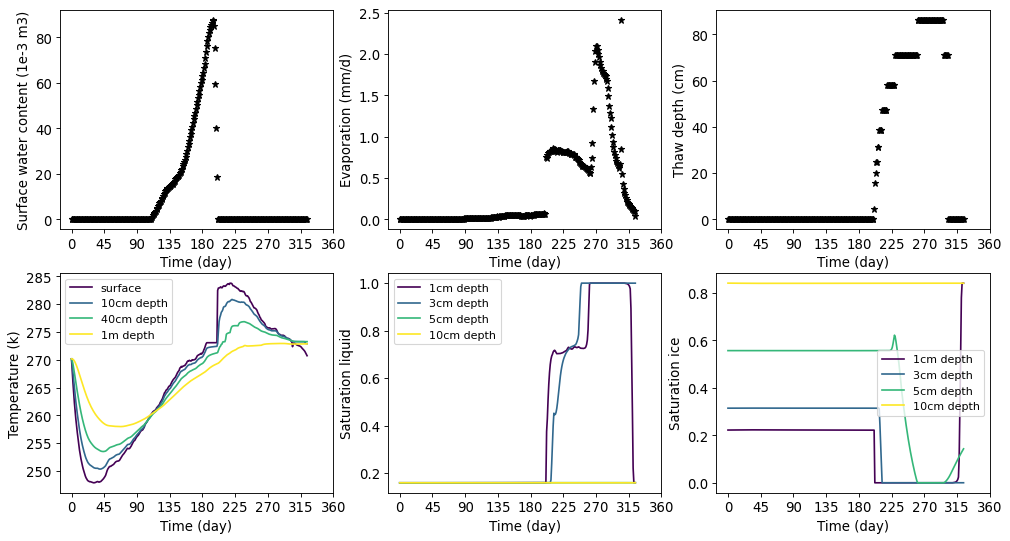

In [64]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

In [65]:
df_simulated_2017 = df_observation.iloc[1:].copy()
df_simulated_2017.head()

,time [s],water content [mol],surface water content [mol],snow water equivalent [mol],evaporation rate [m s^-1],discharge [mol s^-1],surface-subsurface flux [mol s^-1],precipitation rain [m s^-1],precipitation snow [m s^-1],snow melt [m s^-1],...,point -0.01 saturation ice,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice
1,86400.0,705948.743581,0.0,0.015701,2.027689e-12,0.0,0.0,0.0,0.0,0.0,...,0.027476,0.028299,0.222014,0.248985,0.314116,0.556367,0.840477,0.840477,0.949996,0.949996
2,172800.0,705948.743581,0.0,0.015701,3.000921e-12,0.0,0.0,0.0,0.0,0.0,...,0.027559,0.028357,0.222010,0.248977,0.314104,0.556355,0.840477,0.840477,0.949996,0.949996
3,259200.0,705948.743581,0.0,0.015700,4.453412e-12,0.0,0.0,0.0,0.0,0.0,...,0.027662,0.028433,0.222012,0.248970,0.314089,0.556337,0.840478,0.840477,0.949996,0.949996
4,345600.0,705948.743581,0.0,0.015700,5.738699e-12,0.0,0.0,0.0,0.0,0.0,...,0.027779,0.028522,0.222022,0.248968,0.314075,0.556313,0.840459,0.840478,0.949996,0.949996
5,432000.0,705948.743581,0.0,0.015699,6.695483e-12,0.0,0.0,0.0,0.0,0.0,...,0.027903,0.028618,0.222040,0.248971,0.314063,0.556286,0.840434,0.840479,0.949996,0.949996


In [66]:
# Coverting saturation to VWC [Liquid]: VWC = saturation * porosity
porosity_peat = 0.85 # Peat layer until 0.385
porosity_mineral = 0.5 # Mineral layer until 

df_simulated_2017['Soil moisture at - 0.04 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.04 saturation liquid']*porosity_peat*100
df_simulated_2017['Soil moisture at - 0.2 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.2 saturation liquid']*porosity_peat*100
df_simulated_2017['Soil moisture at - 0.4 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.4 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 0.8 m (VWC %)'] = df_simulated_2017.loc[:,'point -0.8 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 1.2 m (VWC %)'] = df_simulated_2017.loc[:,'point -1.2 saturation liquid']*porosity_mineral*100
df_simulated_2017['Soil moisture at - 1.6 m (VWC %)'] = df_simulated_2017.loc[:,'point -1.6 saturation liquid']*porosity_mineral*100

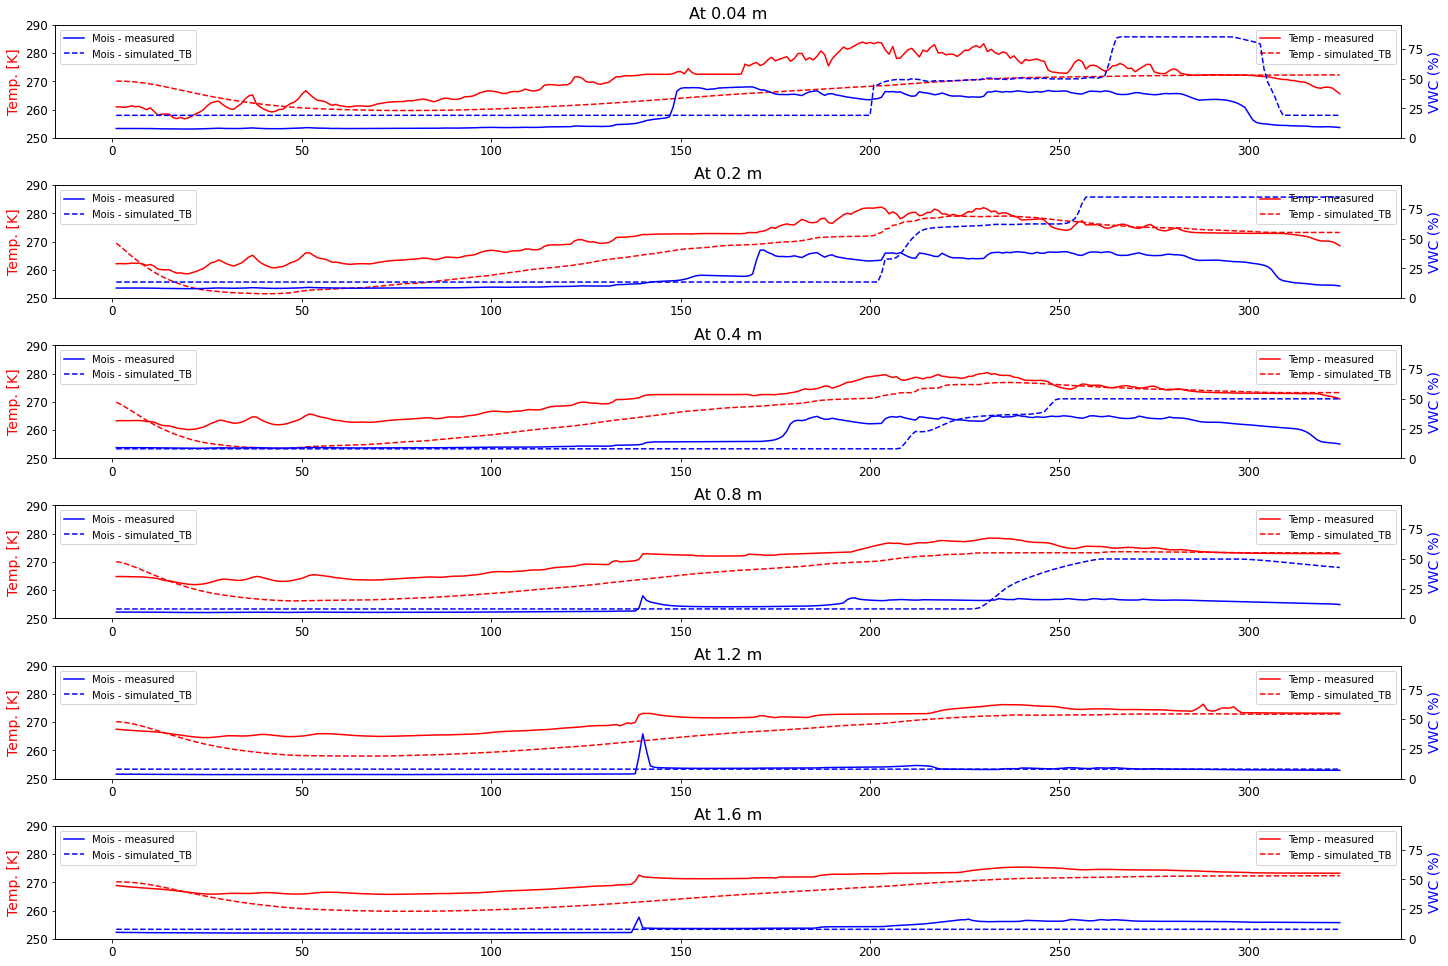

In [68]:
fig2 = plt.figure(figsize=(20,15), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=7, height_ratios=[1,1,1,1,1,1,1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[1, 0])
f2_ax2 = fig2.add_subplot(spec2[2, 0])
f2_ax3 = fig2.add_subplot(spec2[3, 0])
f2_ax4 = fig2.add_subplot(spec2[4, 0])
f2_ax5 = fig2.add_subplot(spec2[5, 0])
f2_ax6 = fig2.add_subplot(spec2[6, 0])

# Defining the x-axis
time = np.arange(1, 325)

# Make a plot

# Plot f2_ax1 - @ 0.04 m
f2_ax1.plot(time, Yakou_measured_data['Soil temperature at - 0.04 m (K)'][:324], 'r',label='Temp - measured')
f2_ax1.plot(time, df_simulated_2017['point -1.6 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax1.plot(time, df_simulated_2017_2['point -0.04 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax1.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax1.set_xlabel('Date', fontsize=15)
f2_ax1.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax1.set_title('At 0.04 m', fontsize=16)
f2_ax1.set_ylim(250, 290)
f2_ax1.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax1.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.04 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.04 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.04 m (VWC %)'], 'k--',label='Mois - simulated')

#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax2 - @ 0.2 m
f2_ax2.plot(time, Yakou_measured_data['Soil temperature at - 0.2 m (K)'][:324], 'r',label='Temp - measured')
f2_ax2.plot(time, df_simulated_2017['point -0.2 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax2.plot(time, df_simulated_2017_2['point -0.2 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax2.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax2.set_xlabel('Date', fontsize=15)
f2_ax2.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax2.set_title('At 0.2 m', fontsize=16)
f2_ax2.set_ylim(250, 290)
f2_ax2.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax2.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.2 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.2 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.2 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax3 - @ 0.4 m
f2_ax3.plot(time, Yakou_measured_data['Soil temperature at - 0.4 m (K)'][:324], 'r',label='Temp - measured')
f2_ax3.plot(time, df_simulated_2017['point -0.4 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax3.plot(time, df_simulated_2017_2['point -0.4 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax3.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax3.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax3.set_title('At 0.4 m', fontsize=16)
f2_ax3.set_ylim(250, 290)
f2_ax3.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax3.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.4 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.4 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.4 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)



# Plot f2_ax4 - @ 0.8 m
f2_ax4.plot(time, Yakou_measured_data['Soil temperature at - 0.8 m (K)'][:324], 'r',label='Temp - measured')
f2_ax4.plot(time, df_simulated_2017['point -0.8 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax4.plot(time, df_simulated_2017_2['point -0.8 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax4.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax4.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax4.set_title('At 0.8 m', fontsize=16)
f2_ax4.set_ylim(250, 290)
f2_ax4.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax4.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 0.8 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 0.8 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 0.8 m (VWC %)'], 'k--',label='Mois - simulated')

#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)

# Plot f2_ax4 - @ 1.2 m
f2_ax5.plot(time, Yakou_measured_data['Soil temperature at - 1.2 m (K)'][:324], 'r',label='Temp - measured')
f2_ax5.plot(time, df_simulated_2017['point -1.2 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax5.plot(time, df_simulated_2017_2['point -1.2 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax5.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax5.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax5.set_title('At 1.2 m', fontsize=16)
f2_ax5.set_ylim(250, 290)
f2_ax5.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax5.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 1.2 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 1.2 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 1.2 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)



# Plot f2_ax6 - @ 1.6 m
f2_ax6.plot(time, Yakou_measured_data['Soil temperature at - 1.6 m (K)'][:324], 'r',label='Temp - measured')
f2_ax6.plot(time, df_simulated_2017['point -1.6 temperature [K]'],'r--',label='Temp - simulated_TB')
#f2_ax6.plot(time, df_simulated_2017_2['point -1.6 temperature [K]'],'y--',label='Temp - simulated')
#f2_ax6.hlines(y=273.15, xmin=datetime(2017, 1, 1), xmax=datetime(2017, 12, 31), color='k', linestyle='--')
#f2_ax3.set_xlabel('Date', fontsize=15)
f2_ax6.set_ylabel('Temp. [K]', fontsize=14,color='r')
f2_ax6.set_title('At 1.6 m', fontsize=16)
f2_ax6.set_ylim(250, 290)
f2_ax6.legend()
# https://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib


ax2 = f2_ax6.twinx()
ax2.plot(time, Yakou_measured_data['Soil moisture at - 1.6 m (%)'][:324], 'b',label='Mois - measured')
ax2.plot(time, df_simulated_2017['Soil moisture at - 1.6 m (VWC %)'], 'b--',label='Mois - simulated_TB')
#ax2.plot(time, df_simulated_2017_2['Soil moisture at - 1.6 m (VWC %)'], 'k--',label='Mois - simulated')
#ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('VWC (%)', fontsize=14, color='b')
ax2.set_ylim(0, 95)
ax2.legend(loc=2)